<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>


In [42]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

// needed to generate the Table of contents 
// taken from github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

In [43]:
#To work with Atom and Jupyter at the same time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploratory Data Analysis

## Explore Data Relationships


In [44]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
#from matplotlib import gridspec #gridspec allows me to make a subplot with different aspect ratio
#from IPython.display import Image #used to display images saved to disk

sns.set() #setting default Seaborn plot style

In [45]:
import pandas_profiling
from pandas_profiling.utils.cache import cache_file

In [48]:
from sklearn.cluster import KMeans




In [46]:
os.chdir('..')
print(os.getcwd())

/home/andrea/Dropbox/PyProjects


In [47]:
filename = 'train.csv' 
#try also 'data/test.csv' and 'data/RUL.csv' for similar results
file_path = 'data/'+filename
df = pd.read_csv(file_path)

FileNotFoundError: [Errno 2] File data/train.csv does not exist: 'data/train.csv'

In [78]:
df.head(5)

,unit_number,cycle_time,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,dataset,op_regime
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,FD003,3
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,FD003,3
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,FD003,3
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,FD003,3
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,FD003,3


In [79]:
# for convenience, identify the sensor and operational setting columns
s_columns = [col for col in df.columns if col.startswith("s")]
op_setting_columns = [col for col in df.columns if col.startswith("op_setting")]
data_cols = op_setting_columns + s_columns

Generate Pairplot of Operating columns

In [80]:
# pair plot takes way too long there are too many variables

#sns.pairplot(df[s_columns])

### Automatic report with pandas-profiling

In [ ]:
profile_report = df.profile_report(html={'style': {'full_width': True}},progress_bar=False)
profile_report.to_file("figures/data_profiling_report.html")
profile_report

**Takeaways :** Many sensor readings are fairly constant and probably will not be good predictors of the Remaning Usable Life.

### Operating Conditions

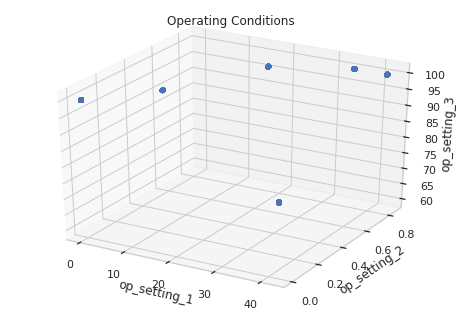

In [72]:
sns.set_style("whitegrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df[op_setting_columns[0]],df[op_setting_columns[1]],df[op_setting_columns[2]])
ax.set_xlabel(op_setting_columns[0])
ax.set_ylabel(op_setting_columns[1])
ax.set_zlabel(op_setting_columns[2])
ax.set_title('Operating Conditions')
plt.show()

We observe that the Operating condistions are clustered in 6 operating regimes.

### Sensor Readings

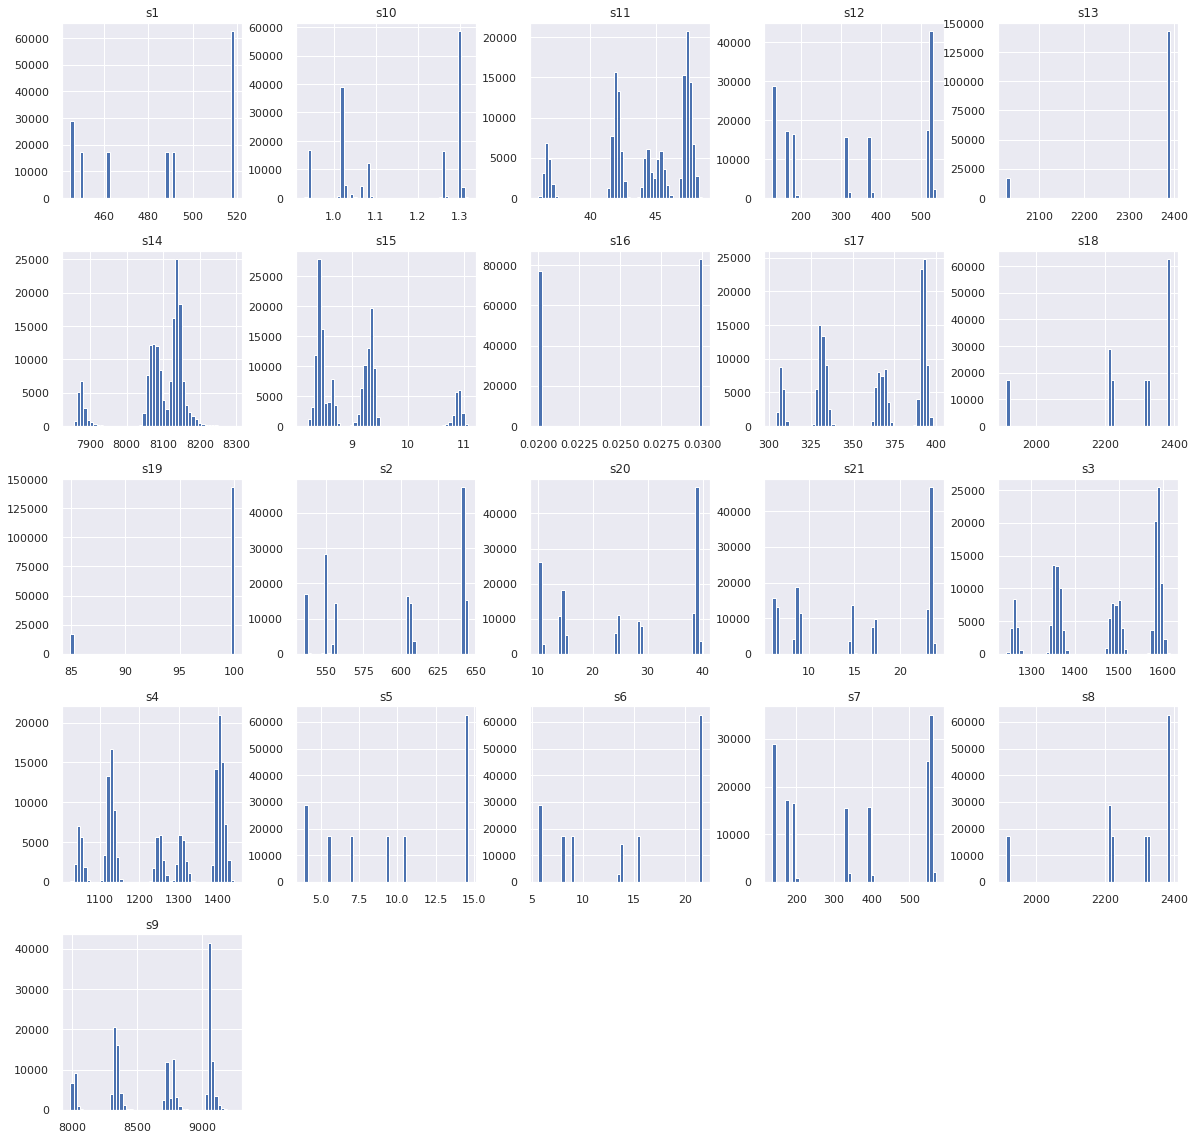

In [93]:
#histograms for each sensor column in df
sns.set_style("darkgrid")

hist = df[s_columns].hist(bins=50, figsize =(20,20))


**Takeaways:** There are several sensor readings that have only a handful of values. Like s13, s16, s19. Sensors with constant values will unlikely be a good predictor of the engine degradation.

## Identification and creation of Features

### 1. Operating Range

As we observed we have 6 operating regimes. Let's cluster the data and create a new variable *op_regime* which can replace the 3 op_settings

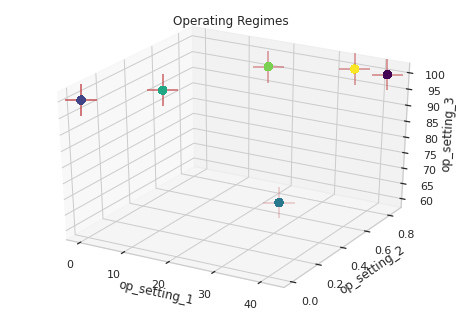

In [74]:
# This code will fit the k-means algorithm with our k parameter set to 6, and plot the results.
op_regimes = df[op_setting_columns].values
kmeans6 = KMeans(n_clusters=6)
y_kmeans6 = kmeans6.fit_predict(op_regimes)

centers = kmeans6.cluster_centers_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(op_regimes[:, 0], op_regimes[:, 1], op_regimes[:, 2], c=y_kmeans3, s=50, cmap='viridis', alpha=0.5)
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], marker='+', c='r', s=1000)

ax.set_xlabel(op_setting_columns[0])
ax.set_ylabel(op_setting_columns[1])
ax.set_zlabel(op_setting_columns[2])
ax.set_title('Operating Regimes')
plt.show()

In [76]:
# Adding a op_regime column to the dataframe
df['op_regime'] = y_kmeans6

In [77]:
df.head()

,unit_number,cycle_time,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,dataset,op_regime
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,FD003,3
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,FD003,3
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,FD003,3
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,FD003,3
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,FD003,3


### 2. Sensor Selection

Let's look at which sensor should we drop for each operating range.

In [21]:
# iterate over unique datasets and unit_numbers. isolating a single timeseries

for dataset in df["dataset"].unique() :
    for unit_number in  df[(df["dataset"] == dataset)]['unit_number'].unique() :
        time_series = df[(df["dataset"] == dataset) & (df["unit_number"] == unit_number)]


IndexError: list index out of range

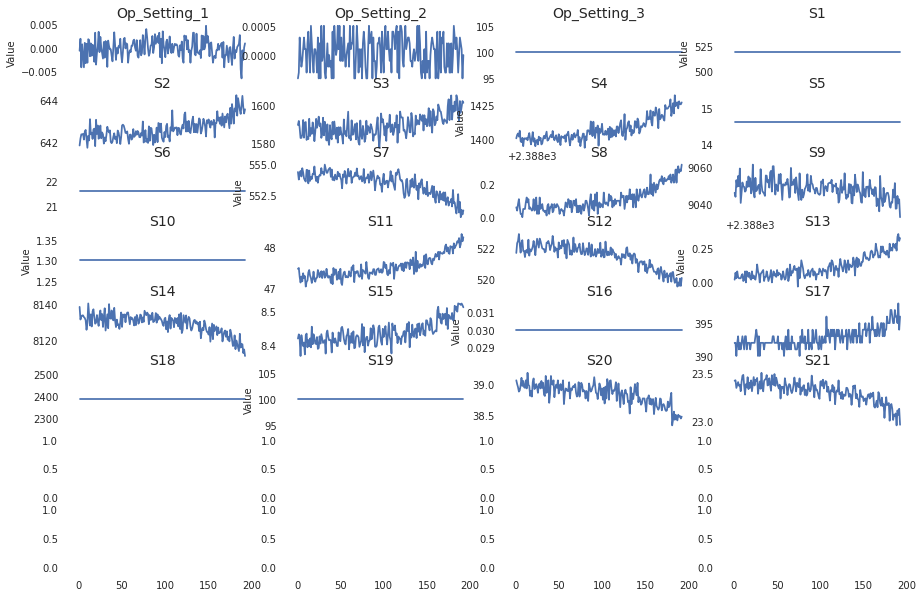

In [22]:
# extract the first unit from the first dataset
example_slice = df[(df["dataset"] == 'FD001') & (df["unit_number"] == 1)]

# plot its traces over time
# note that we need 8 x 3 = 24 plots to see all op_setting and sensor channels
fig, axes = plt.subplots(8, 4, figsize=(15, 10), sharex=True)
for index, ax in enumerate(axes.ravel()):
    # plot the channel corresponding to this position
    data_col = data_cols[index]
    example_slice.plot(x='cycle_time', y=data_col, ax=ax);
    # label formatting
    if index % 3 == 0:
        ax.set_ylabel("Value", size=10);
    else:
        ax.set_ylabel("");
    ax.set_xlabel("Time (Cycles)");
    ax.set_title(data_col.title(), size=14);
    ax.legend_.remove();
# plot formatting
fig.suptitle("Dataset 1, Unit 1", size=20, y=1.025)
fig.tight_layout();


## EDA Conclusions

